# Customer Churn Explanation

## Import Libraries

In [1]:
import pickle

import numpy as np
import pandas as pd
import shap
from shap import Explanation
from shap.plots import bar, beeswarm, heatmap, waterfall
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    confusion_matrix,
    f1_score,
    make_scorer,
    precision_score,
    recall_score,
)
from sklearn.model_selection import (
    StratifiedKFold,
    cross_val_predict,
    cross_validate,
    train_test_split,
)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

## Churn Prediction Models Evaluation

In [2]:
# Set random state
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

In [3]:
# Read dataset from pickle
with open("data/clients_dataset.pickle", "rb") as handle:
    dataset = pickle.load(handle)

X = dataset.drop("PREDICTION", axis=1)
y = dataset["PREDICTION"]

In [4]:
# Define Stratified 10-fold Cross-Validation
kfold = StratifiedKFold(n_splits=10, random_state=RANDOM_STATE, shuffle=True)

# Define Models
models = [
    ("Logistic Regression", LogisticRegression(max_iter=10_000_000_000)),
    ("Random Forest Classifier", RandomForestClassifier()),
    ("K-Nearest Neighbors", KNeighborsClassifier()),
]

# Define Evaluation Metrics
scorer = {
    "accuracy": "accuracy",
    "precision_NO_CHURN": make_scorer(
        precision_score, pos_label="NO CHURN", zero_division=0
    ),
    "precision_CHURN": make_scorer(precision_score, pos_label="CHURN", zero_division=0),
    "recall_NO_CHURN": make_scorer(recall_score, pos_label="NO CHURN", zero_division=0),
    "recall_CHURN": make_scorer(recall_score, pos_label="CHURN", zero_division=0),
    "f1_NO_CHURN": make_scorer(f1_score, pos_label="NO CHURN", zero_division=0),
    "f1_CHURN": make_scorer(f1_score, pos_label="CHURN", zero_division=0),
}

print("Models Evaluation")
for name, model in models:
    print("\nModel Name: " + name)

    # Create a pipeline with a StandardScaler before the model if the model is KNN
    if name == "K-Nearest Neighbors":
        model_pipeline = make_pipeline(StandardScaler(), model)
        results = cross_validate(
            model_pipeline, X, y, cv=kfold, scoring=scorer, return_estimator=True
        )
        y_pred = cross_val_predict(model_pipeline, X, y, cv=kfold)
    else:
        results = cross_validate(
            model, X, y, cv=kfold, scoring=scorer, return_estimator=True
        )
        y_pred = cross_val_predict(model, X, y, cv=kfold)

    cmtx = pd.DataFrame(
        confusion_matrix(y, y_pred, labels=["CHURN", "NO CHURN"]),
        index=["true:CHURN", "true:NO CHURN"],
        columns=["pred:CHURN", "pred:NO CHURN"],
    )
    print("\nConfusion Matrix:")
    print(cmtx)

    print("\nEvaluation Metrics:")
    print(
        "\n{:<10s} {:<10s} {:<10s} {:<10s}".format(
            "", "Precision", "Recall", "F1 Score"
        )
    )
    print(
        "{:<10s} {:.2f} {:10.2f} {:10.2f}".format(
            "NO CHURN",
            results["test_precision_NO_CHURN"].mean(),
            results["test_recall_NO_CHURN"].mean(),
            results["test_f1_NO_CHURN"].mean(),
        )
    )
    print(
        "{:<10s} {:.2f} {:10.2f} {:10.2f}".format(
            "CHURN",
            results["test_precision_CHURN"].mean(),
            results["test_recall_CHURN"].mean(),
            results["test_f1_CHURN"].mean(),
        )
    )
    print(
        "\n{:<10s} {:.2f} {:10.2f} {:10.2f}\n".format(
            "Average",
            (
                results["test_precision_NO_CHURN"].mean()
                + results["test_precision_CHURN"].mean()
            )
            / 2,
            (
                results["test_recall_NO_CHURN"].mean()
                + results["test_recall_CHURN"].mean()
            )
            / 2,
            (results["test_f1_NO_CHURN"].mean() + results["test_f1_CHURN"].mean()) / 2,
        )
    )
    print("{:<10s} {:.2f} ".format("Accuracy", results["test_accuracy"].mean()))
    print("\n\n\n")

Models Evaluation

Model Name: Logistic Regression

Confusion Matrix:
               pred:CHURN  pred:NO CHURN
true:CHURN             82             31
true:NO CHURN           9            100

Evaluation Metrics:

           Precision  Recall     F1 Score  
NO CHURN   0.78       0.92       0.84
CHURN      0.90       0.72       0.79

Average    0.84       0.82       0.81

Accuracy   0.82 





Model Name: Random Forest Classifier

Confusion Matrix:
               pred:CHURN  pred:NO CHURN
true:CHURN            104              9
true:NO CHURN          15             94

Evaluation Metrics:

           Precision  Recall     F1 Score  
NO CHURN   0.92       0.86       0.88
CHURN      0.88       0.91       0.89

Average    0.90       0.89       0.89

Accuracy   0.89 





Model Name: K-Nearest Neighbors

Confusion Matrix:
               pred:CHURN  pred:NO CHURN
true:CHURN             93             20
true:NO CHURN          27             82

Evaluation Metrics:

           Precision  Re

## Churn Prediction Models Explanation

In [5]:
# Initialize SHAP JavaScript Library
shap.initjs()

In [6]:
# Split dataset in train and test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

# Create a standard scaler
scaler = StandardScaler()
# Fit the scaler on the training set only to avoid data leakage
X_train_scaled = scaler.fit_transform(X_train)
# Scale the test set with the previously fitted scaler
X_test_scaled = scaler.transform(X_test)
# Transform scaled datasets in Pandas Dataframes
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

# Define data to be used for SHAP explanations
background_data = X_train
background_data_scaled = X_train_scaled
explanation_data = X_test
explanation_data_scaled = X_test_scaled

# Create list of feature names
features_list = X.columns.to_list()

### Random Forest Classifier

In [7]:
# Create and fit the model
tree = RandomForestClassifier()
tree.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [8]:
# Create the explainer and give it the background data
tree_explainer = shap.KernelExplainer(
    tree.predict_proba, background_data, seed=RANDOM_STATE
)
# Get the SHAP values from the explainer for the given explanation data
tree_shap_values = tree_explainer.shap_values(explanation_data)
# Create a SHAP explanation to plot results
tree_shap_explanation = Explanation(
    tree_shap_values[0],
    tree_explainer.expected_value[0],
    explanation_data,
    feature_names=features_list,
)

Using 177 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/45 [00:00<?, ?it/s]

#### Global Explanation

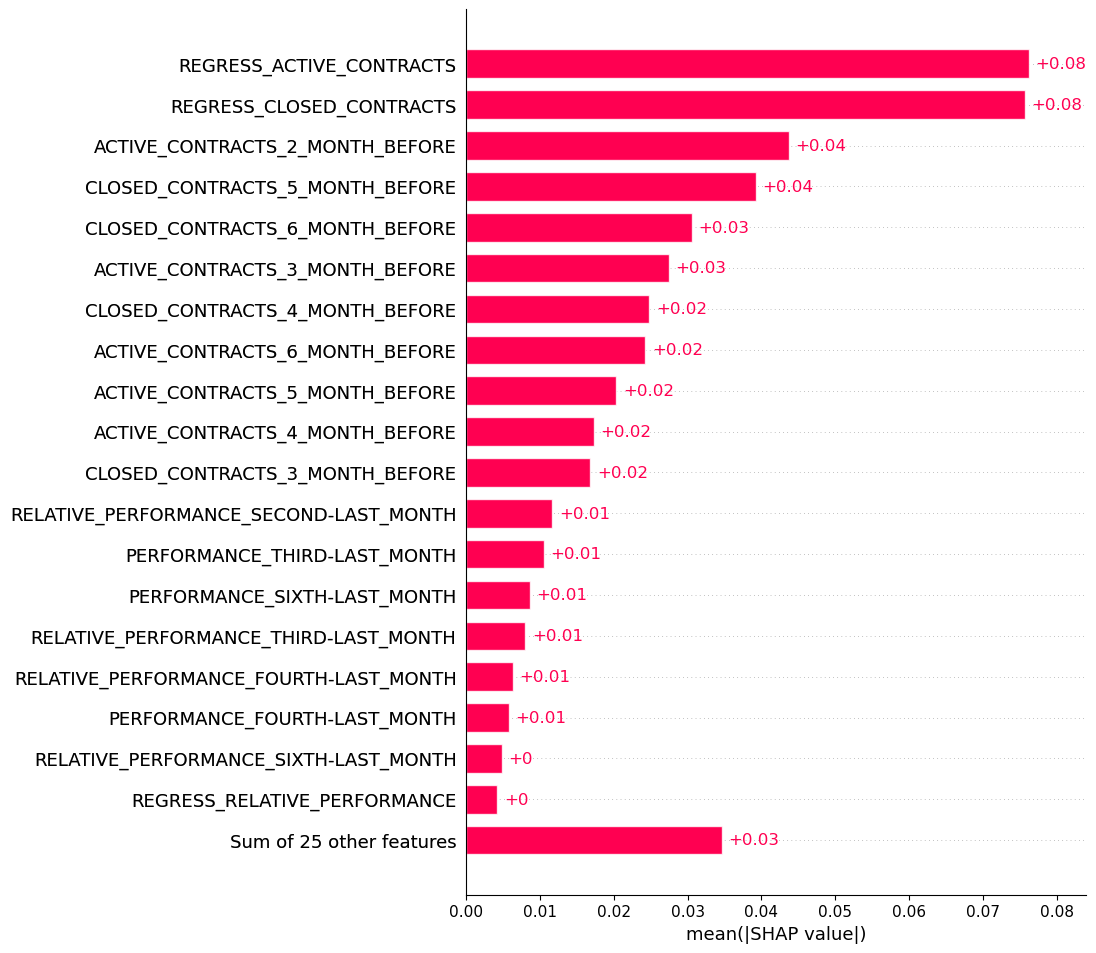

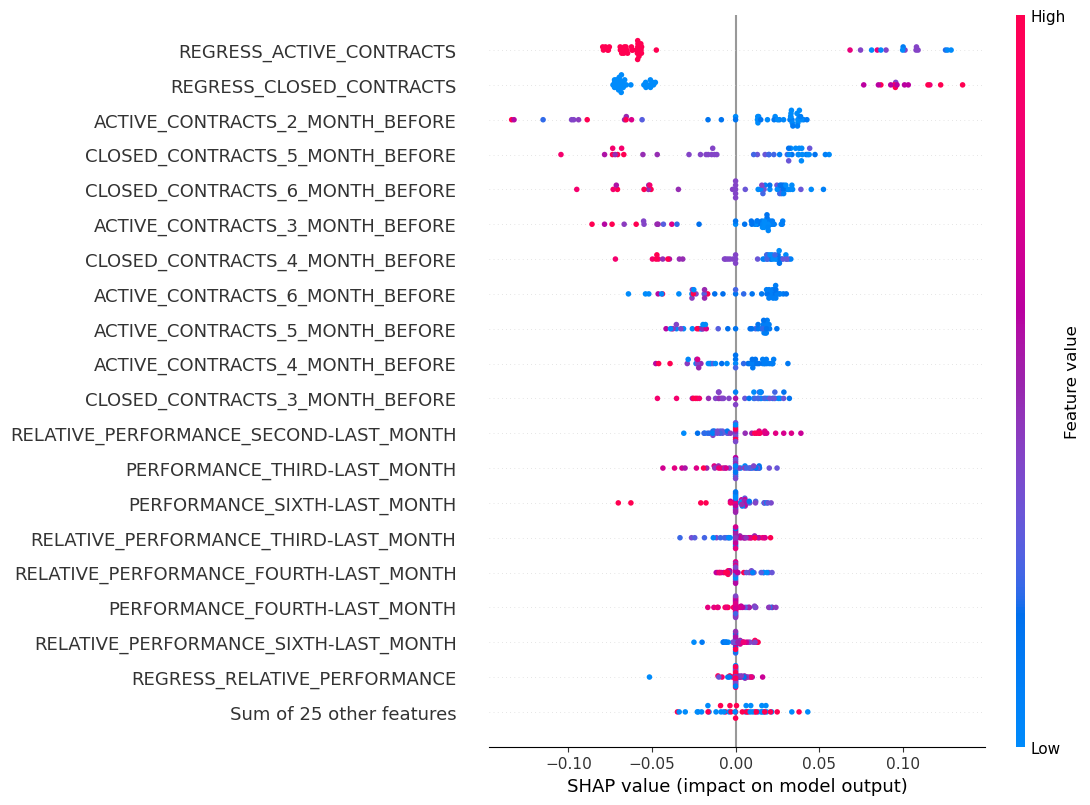

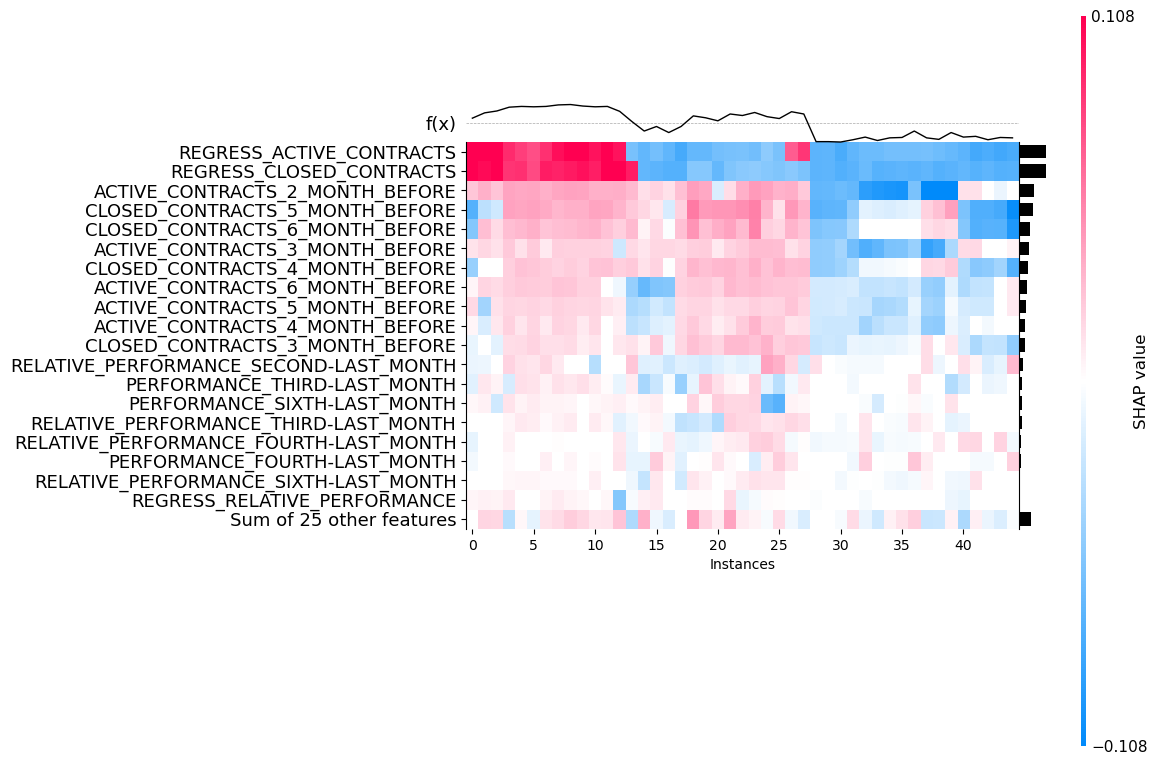

In [9]:
bar(tree_shap_explanation, max_display=20)
beeswarm(tree_shap_explanation, max_display=20)
heatmap(tree_shap_explanation, max_display=20)

#### Local Explanation

CHURN probability: 0.67
Prediction: CHURN


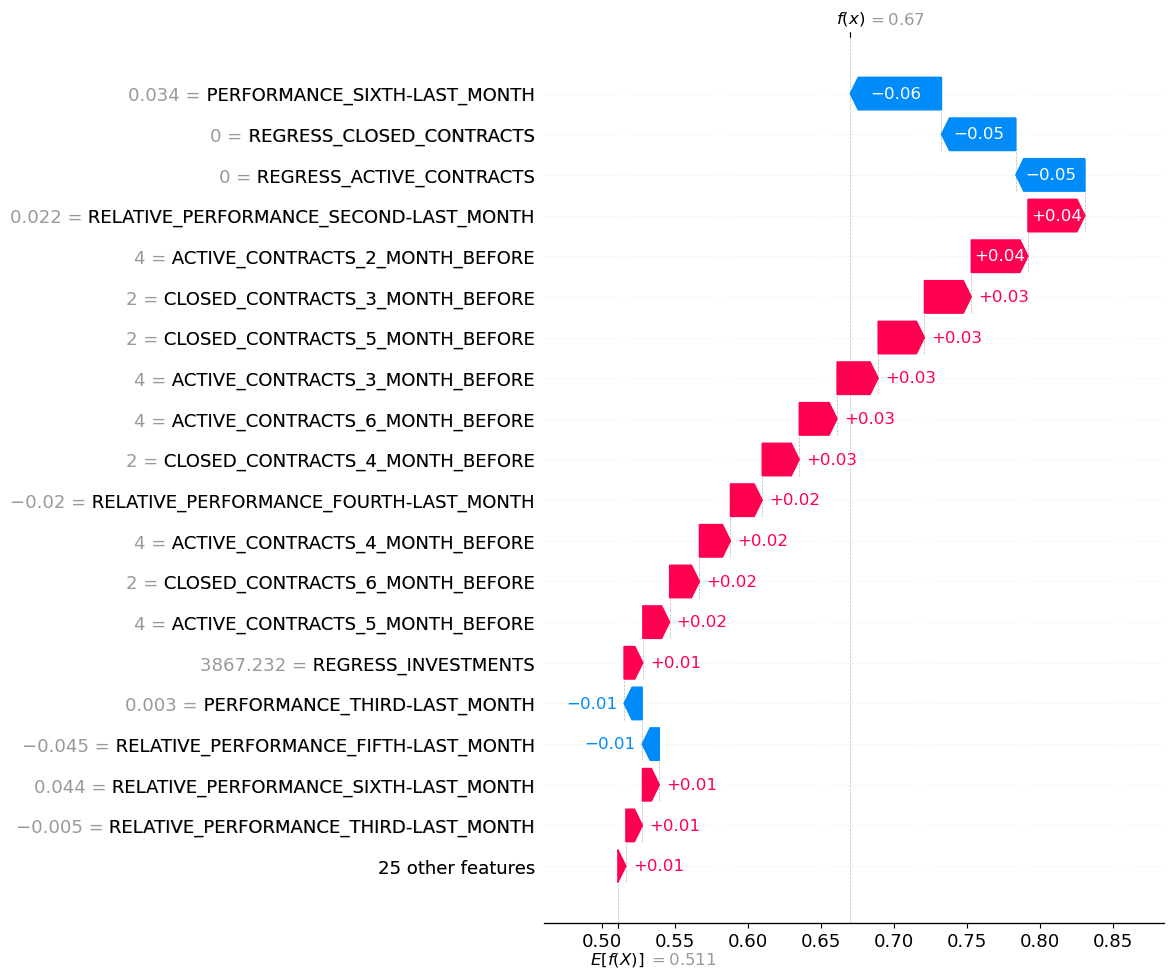

In [10]:
prediction_id = 5
print("CHURN probability:", tree.predict_proba(X_test)[prediction_id][0])
print("Prediction:", tree.predict(X_test)[prediction_id])
waterfall(tree_shap_explanation[prediction_id], max_display=20)

CHURN probability: 0.01
Prediction: NO CHURN


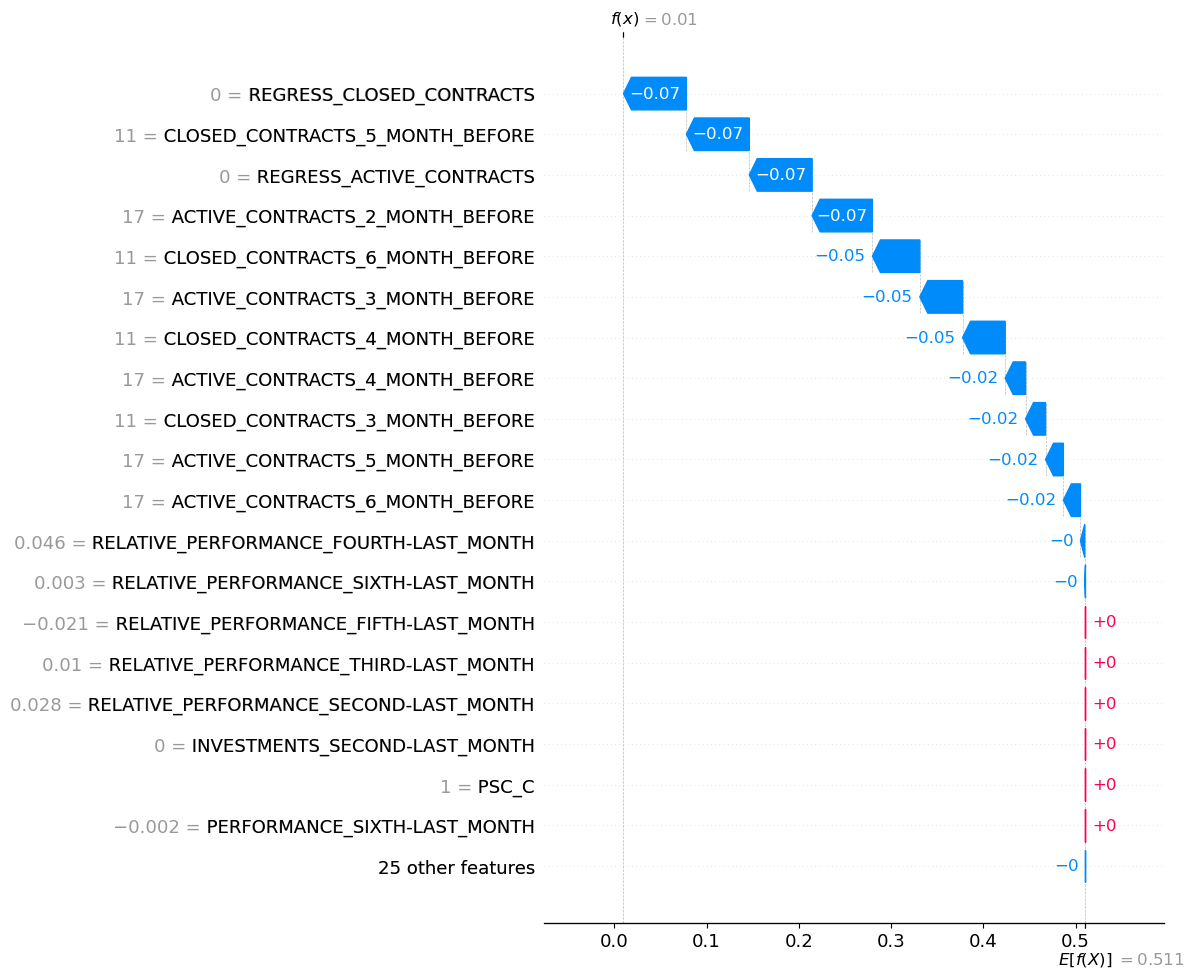

In [11]:
prediction_id = 2
print("CHURN probability:", tree.predict_proba(X_test)[prediction_id][0])
print("Prediction:", tree.predict(X_test)[prediction_id])
waterfall(tree_shap_explanation[prediction_id], max_display=20)

### Logistic Regression

In [12]:
# Create and fit the model
logreg = LogisticRegression(max_iter=10_000_000_000)
logreg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10000000000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [13]:
# Create the explainer and give it the background data
logreg_explainer = shap.KernelExplainer(
    logreg.predict_proba, background_data, seed=RANDOM_STATE
)
# Get the SHAP values from the explainer for the given explanation data
logreg_shap_values = logreg_explainer.shap_values(explanation_data)
# Create a SHAP explanation to plot results
logreg_shap_explanation = Explanation(
    logreg_shap_values[0],
    logreg_explainer.expected_value[0],
    explanation_data,
    feature_names=features_list,
)

Using 177 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/45 [00:00<?, ?it/s]

#### Global Explanation

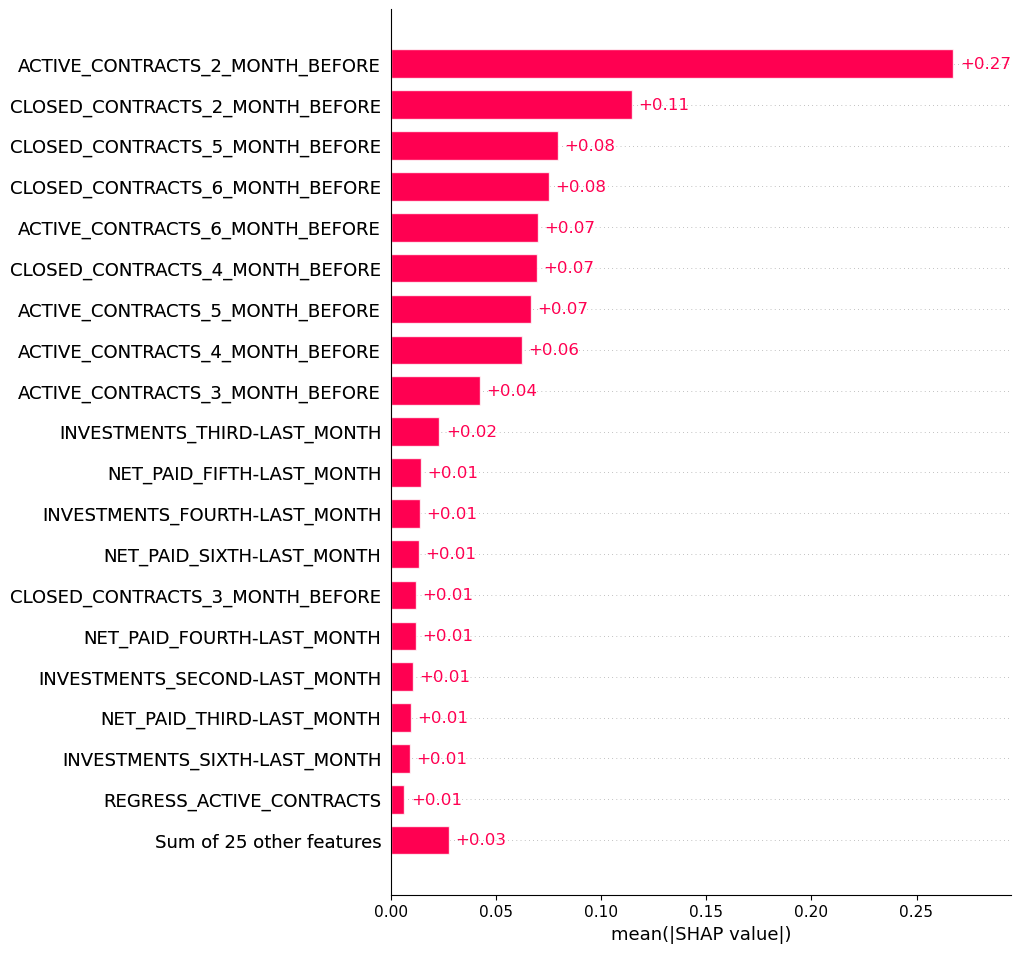

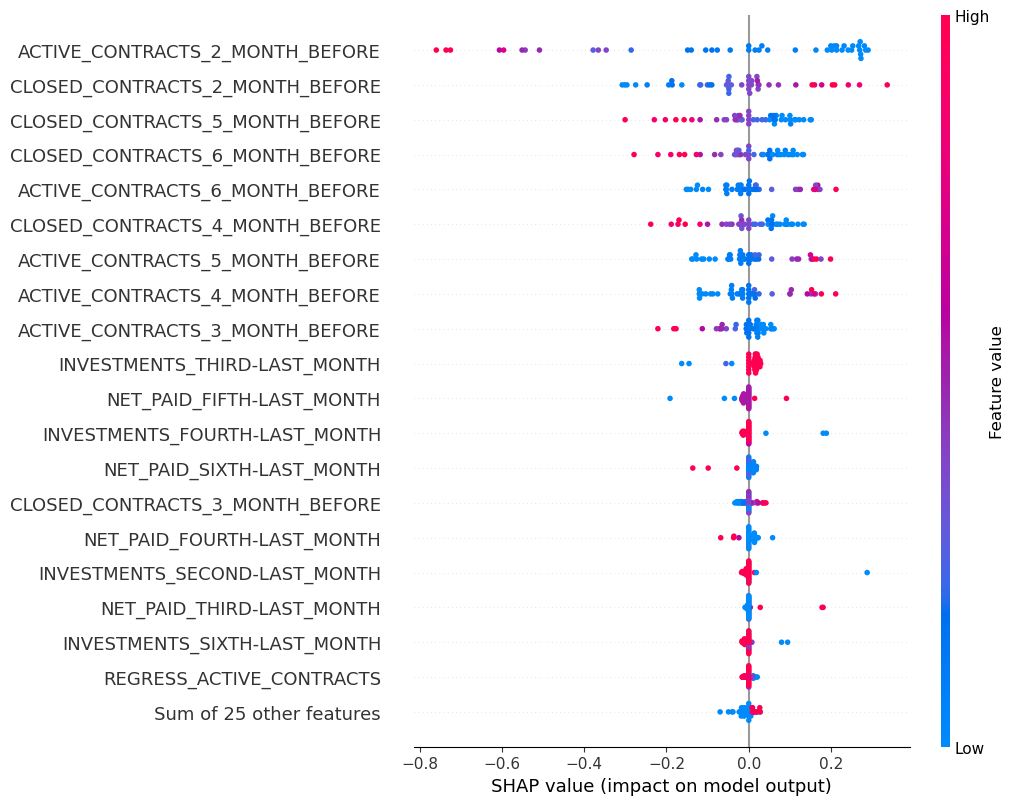

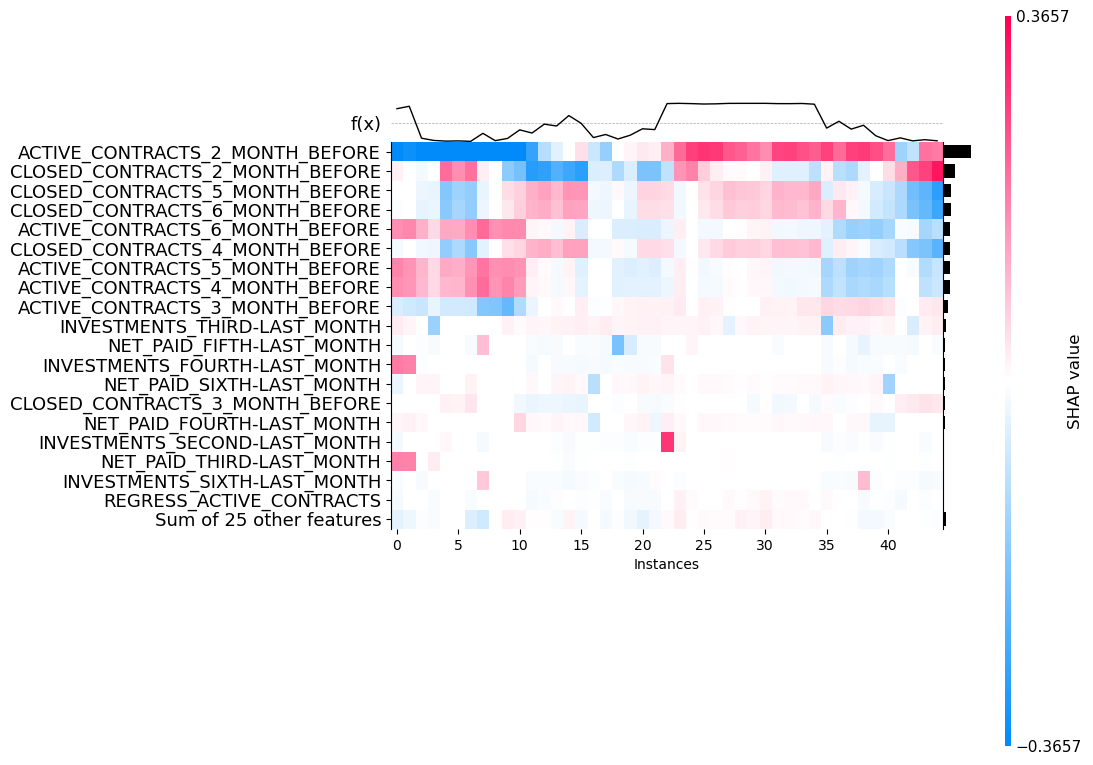

In [14]:
bar(logreg_shap_explanation, max_display=20)
beeswarm(logreg_shap_explanation, max_display=20)
heatmap(logreg_shap_explanation, max_display=20)

#### Local Explanation

CHURN probability: 0.3099100758566884
Prediction: NO CHURN


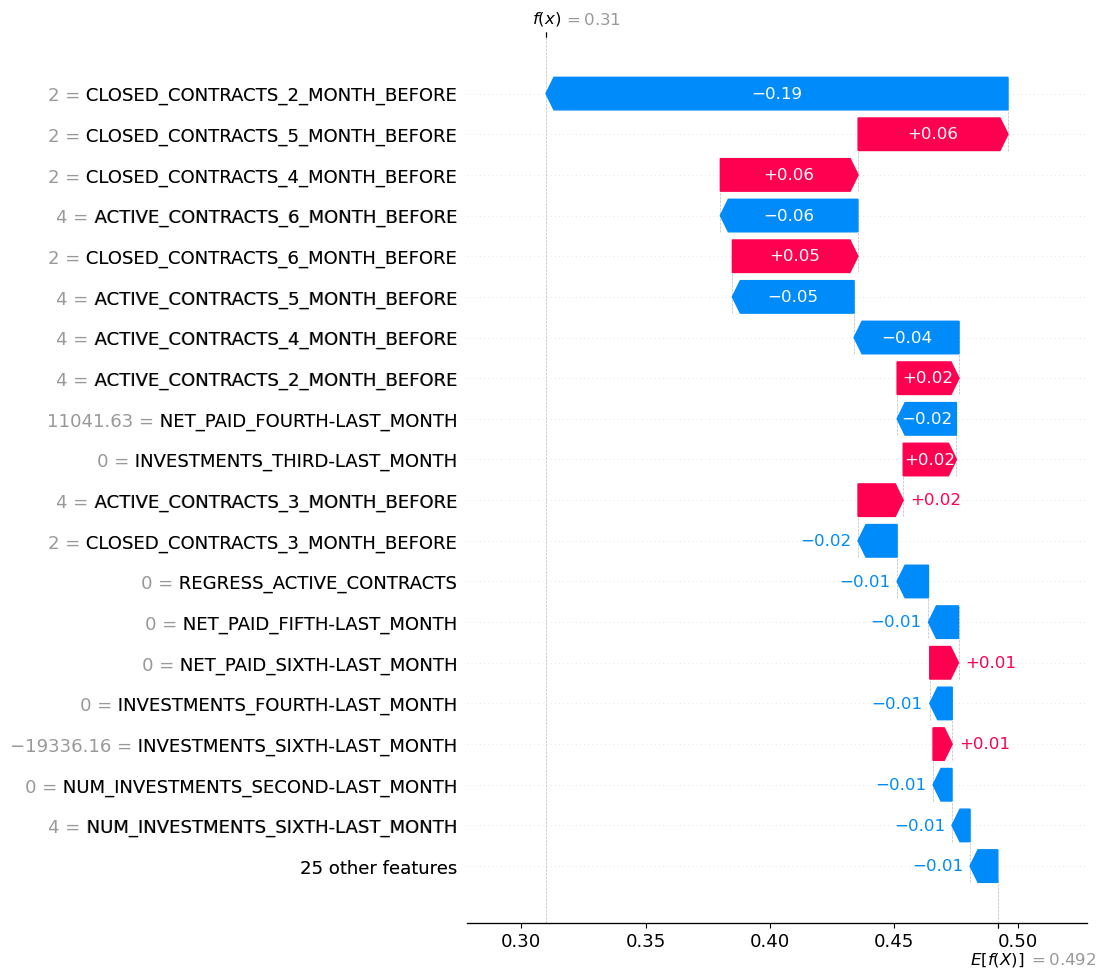

In [15]:
prediction_id = 5
print("CHURN probability:", logreg.predict_proba(X_test)[prediction_id][0])
print("Prediction:", logreg.predict(X_test)[prediction_id])
waterfall(logreg_shap_explanation[prediction_id], max_display=20)

CHURN probability: 0.012826334497665792
Prediction: NO CHURN


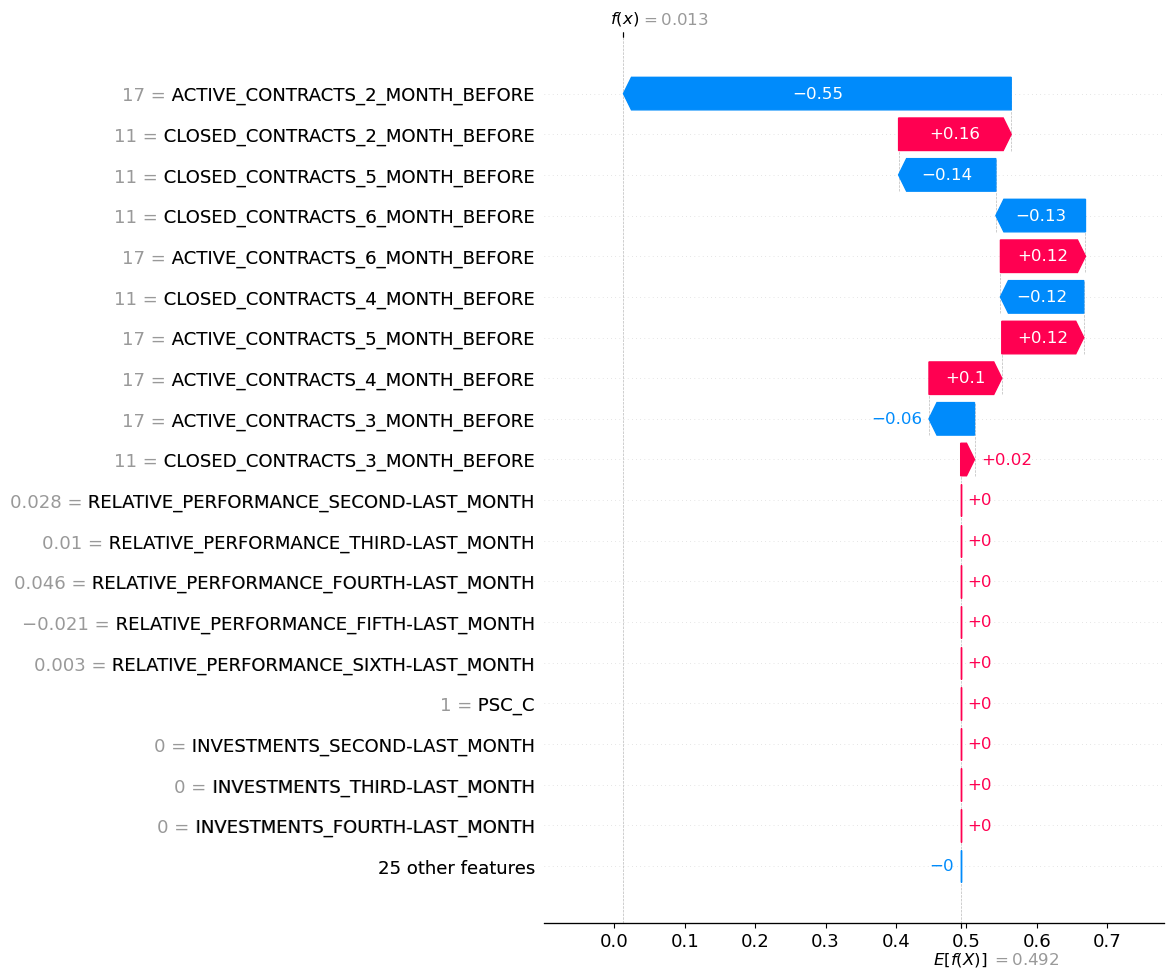

In [16]:
prediction_id = 2
print("CHURN probability:", logreg.predict_proba(X_test)[prediction_id][0])
print("Prediction:", logreg.predict(X_test)[prediction_id])
waterfall(logreg_shap_explanation[prediction_id], max_display=20)

### K-Nearest Neighbors

In [17]:
# Create and fit the model
knn = KNeighborsClassifier()
knn.fit(X_train_scaled, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [18]:
# Create the explainer and give it the background data
knn_explainer = shap.KernelExplainer(
    knn.predict_proba, background_data_scaled, seed=RANDOM_STATE
)
# Get the SHAP values from the explainer for the given explanation data
knn_shap_values = knn_explainer.shap_values(explanation_data_scaled)
# Create a SHAP explanation to plot results
knn_shap_explanation = Explanation(
    knn_shap_values[0],
    knn_explainer.expected_value[0],
    explanation_data,
    feature_names=features_list,
)

Using 177 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/45 [00:00<?, ?it/s]

#### Global Explanation

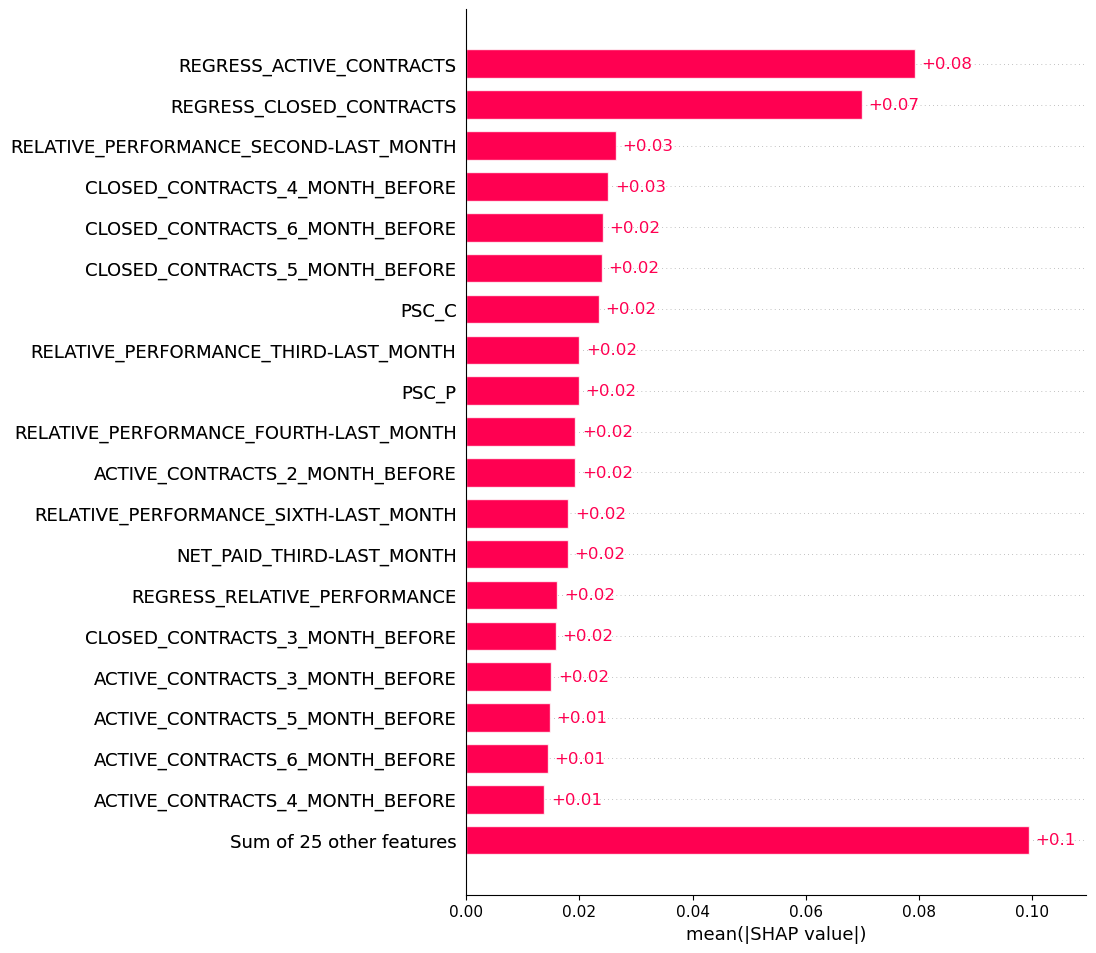

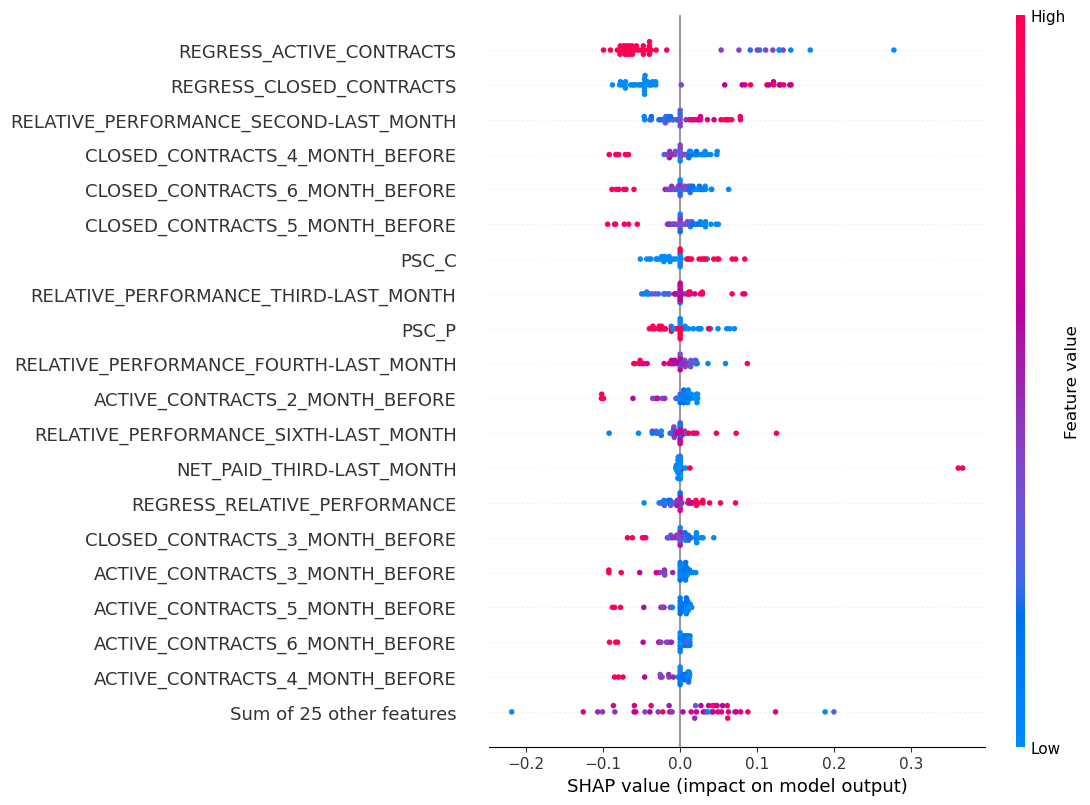

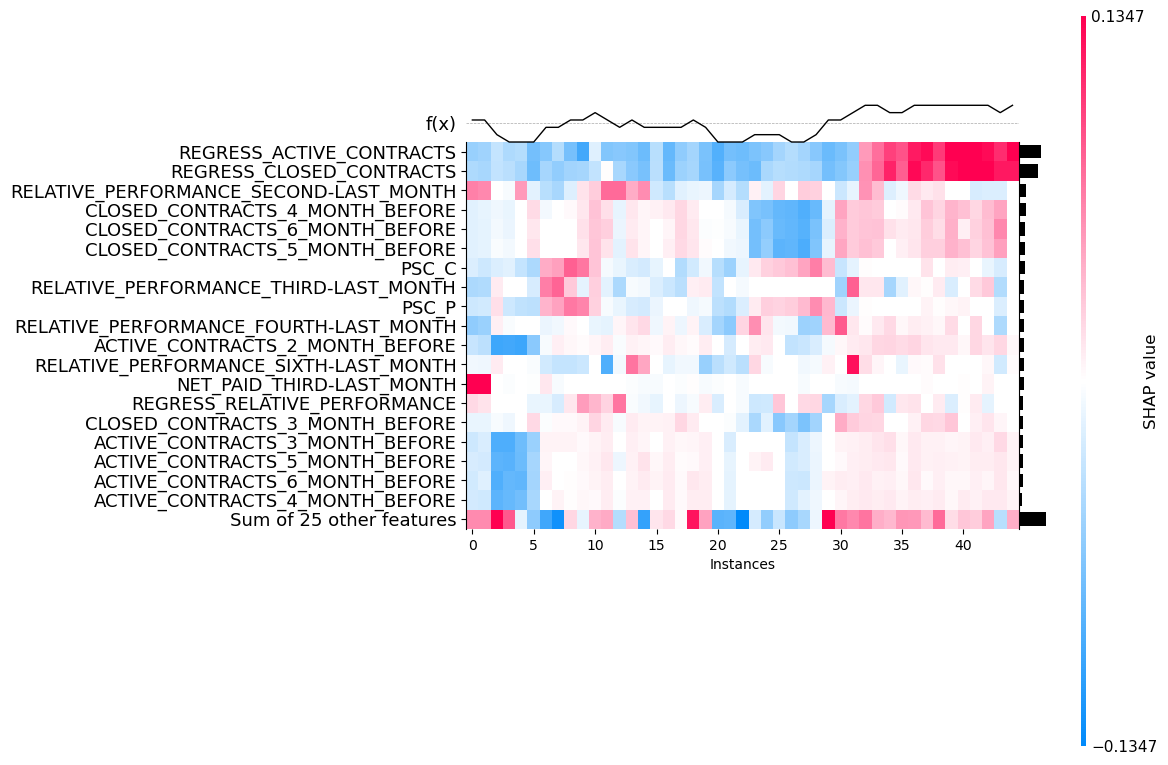

In [19]:
bar(knn_shap_explanation, max_display=20)
beeswarm(knn_shap_explanation, max_display=20)
heatmap(knn_shap_explanation, max_display=20)

#### Local Explanation

CHURN probability: 0.6
Prediction: CHURN


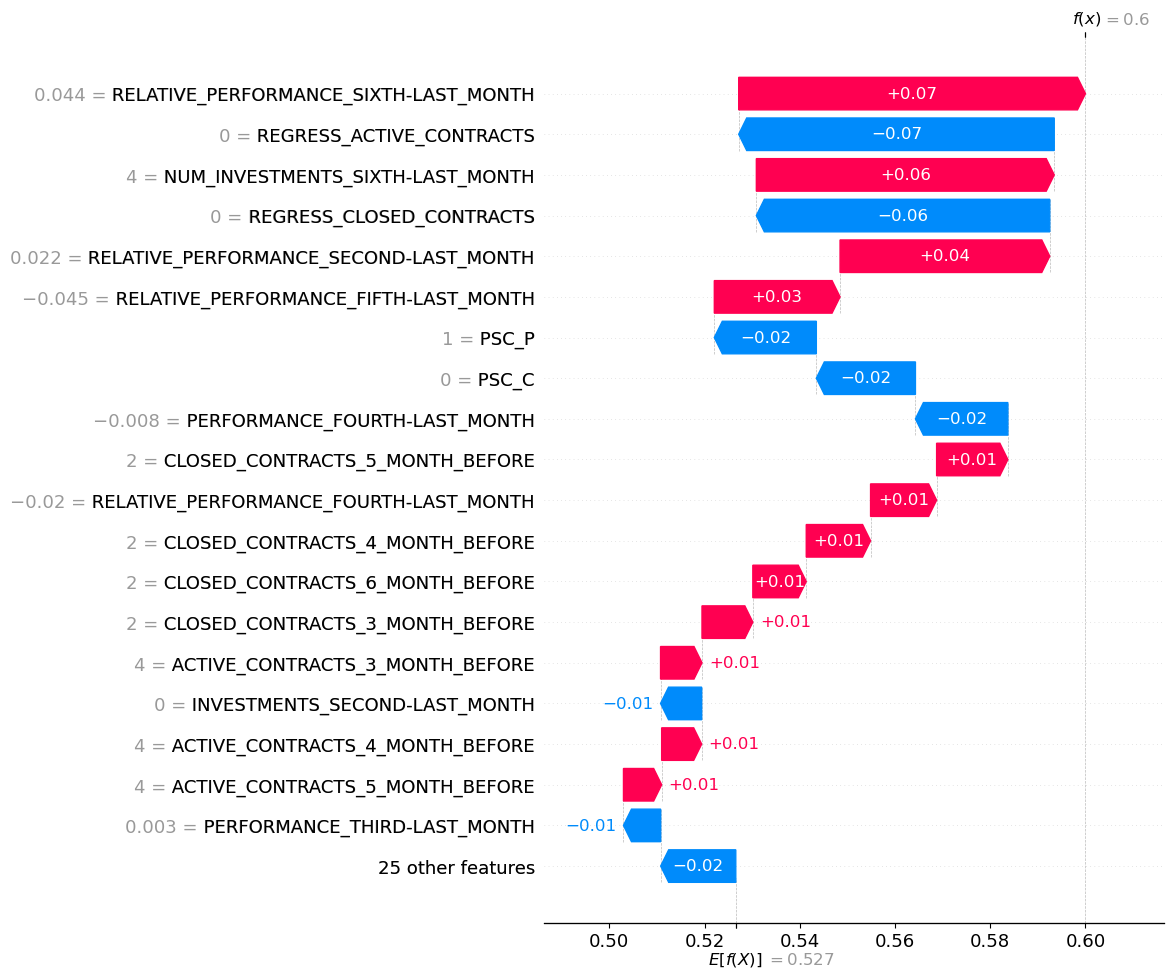

In [20]:
prediction_id = 5
print("CHURN probability:", knn.predict_proba(X_test_scaled)[prediction_id][0])
print("Prediction:", knn.predict(X_test_scaled)[prediction_id])
waterfall(knn_shap_explanation[prediction_id], max_display=20)

CHURN probability: 0.2
Prediction: NO CHURN


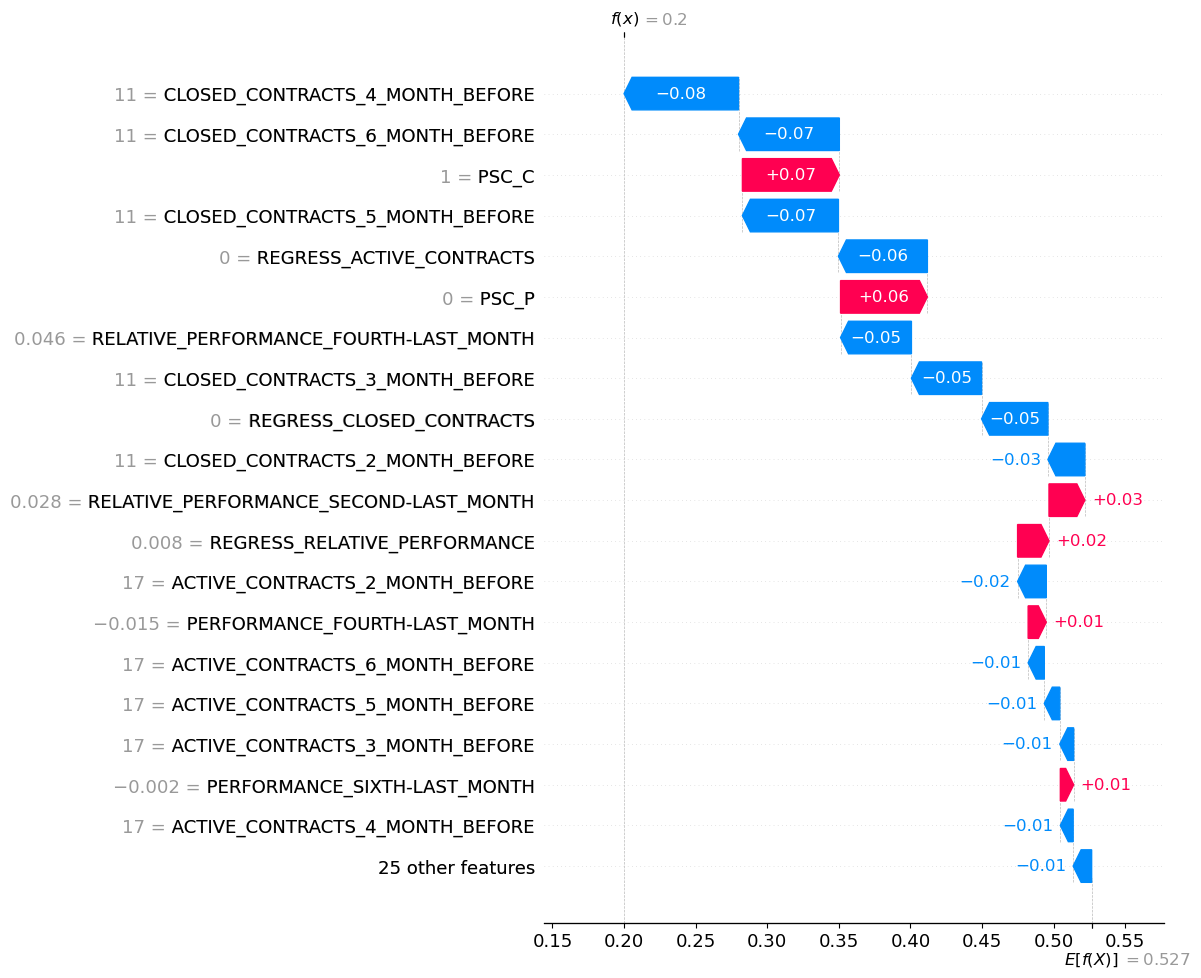

In [21]:
prediction_id = 2
print("CHURN probability:", knn.predict_proba(X_test_scaled)[prediction_id][0])
print("Prediction:", knn.predict(X_test_scaled)[prediction_id])
waterfall(knn_shap_explanation[prediction_id], max_display=20)